In [1]:
import sys
sys.path.insert(0, '..')

%load_ext tools.prov_magics
import tools.view.mutable_prov
from tools.query.mutable_prov import *

In [2]:
from collections import namedtuple
from copy import copy
Context = namedtuple("Context", "type node moment")

def wdf_text(e2, e1, a, attrs):
    return querier.text("wasDerivedFrom", [e2, e1, a], attrs=dict(attrs), id_=None)

def neighborhood(context):
    type_, n, t0 = context
    if type_ == "entity":
        # yield* Context(D,0) from wasDerivedFrom(N,D)
        D, A, AT, TX = var(4)
        for __ in wasDerivedFrom(n, D, A, attrs=AT) & entity(D, text=TX):
            yield Context("entity", D.bound, None), {wdf_text(n, D.bound, A.bound, AT.bound), TX.bound}
        
        # yield? Context(V,T) from accessed(N,V,T)
        V, T, TX1, TX2 = var(4)
        for __ in accessed(n, V, T, text=TX1) & value(V, text=TX2):
            yield Context("value", V.bound, T.bound), {TX1.bound, TX2.bound}
            
        # yield? Context(V,T) from defined(N,V,T), T != T0
        V, T, TX1, TX2 = var(4)
        for __ in defined(n, V, T, text=TX1) &  value(V, text=TX2):
            if T.bound != t0:
                yield Context("value", V.bound, T.bound), {TX1.bound, TX2.bound}
            
        # if match accessedPart(N,W,K,P,T)
        W, K, P, Y, TX1, TX2, TX3 = var(7)
        for __ in accessedPart(n, W, K, P, T, TX1) &  value(P, TX2) &  value(W, TX3):
            # yield Context(P,T)
            yield Context("value", P.bound, T.bound), {TX1.bound, TX2.bound}
            
            # yield? Context(E,0) from derivedByInsertion(E,W,{(K,P)},-)
            E, CH, T2, TX4, TX5 = var(5)
            for __ in derivedByInsertion(E, W, CH, T2, text=TX4) & entity(E, text=TX5):
                if (K.bound, P.bound) in CH.bound:
                    yield Context("entity", E.bound, None), {TX4.bound, TX5.bound}
            
    if type_ == "value":
        # Sort derivedByInsertion(E,N,{(K,P)},T) and
        #   derivedByRemoval(-,N,-,T) by T
        parts = []
        E, CH, T2, TX1, TX2 = var(5)
        for __ in derivedByInsertion(E, n, CH, T2, text=TX1) & entity(E, text=TX2):
            if T2.bound <= t0:
                parts.append((T2.bound, E.bound, CH.bound, TX1.bound, TX2.bound))
        parts.sort()
        # Reconstruct state to find valid keys at T <= T0
        state = {}
        for t2, e, changes, dtext, etext in parts:
            for key, part in changes:
                state[key] = (part, e, dtext, etext)
        # for each part P of value N valid at T0
        for key, (part, e, dtext, etext) in state.items():
            tresult = {dtext}
            # yield Context(P, T0)
            TX = var(1)
            for __ in value(part, text=TX):
                tresult.add(TX.bound)
            yield Context("value", part, t0), tresult
            # yield Context(E, 0)
            yield Context("entity", e, None), {etext}
        
        # yield? Context(E,T2) from wasDefinedBy(N,E,T2)
        E, TX1, T2, TX2 = var(4)
        for __ in wasDefinedBy(n, E, T2, TX1) &  entity(E, TX2):
            yield Context("entity", E.bound, T2.bound), {TX1.bound, TX2.bound}
            
            
def dfs(ent, neigh):
    context = Context("entity", ent, moment=None)
    stack = [context]
    visited = set()
    text = var("text")
    result = {text.bound for __ in entity(ent, text)} 

    while stack:
        context = stack.pop()
        for other, tresult in neigh(context):
            if other not in visited:
                visited.add(other)
                result |= tresult
                stack.append(other)
    return result



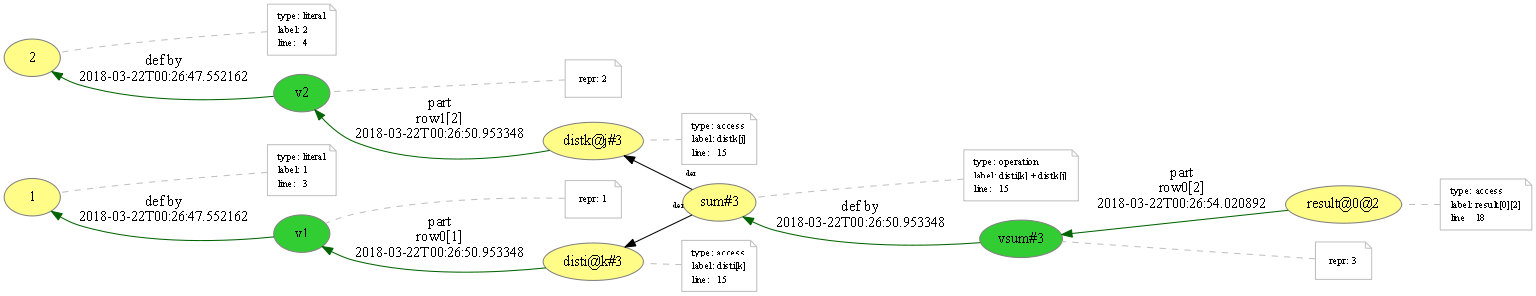

In [3]:
querier.load("../generated/mutable_prov/floydwarshall.provn");
view = "provn png svg pdf"
get_ipython().run_cell_magic(
    "provn",
    "-o {} -e {} -r RL".format("../generated/mutable_prov/query", view),
    '\n'.join(dfs("result@0@2", neighborhood))
)